In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

comment = "Fit to covariance in sim"
nb_name = "nb_midpath_dynamo_covmod_sim"

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)
core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101) #model_hist = "ensemble"

In [3]:
core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



In [4]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Fit to covariance in sim
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  30
N_SH_secondary:        None
sim_type:              core_ens
grid_zero:             (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:        (31,), Max/Min: 0.10 / 0.01
grid_shape:            (2,), Max/Min: 61.00 / 31.00
grid_w:                (1891,), Max/Min: 0.10 / 0.01
grid_radial:           (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:            (1891,), Max/Min: 175.63 / 4.37
grid_phi:              (1891,), Max/Min: 354.10 / 0.00
grid_N:                1891
grid_nmax:             30
r_grid:                3480.0
grid:                  (1891, 2)
sph_d:                 (1891, 1891)
lon:                   (1891,), Max/Min: 354.10 

<IPython.core.display.Javascript object>


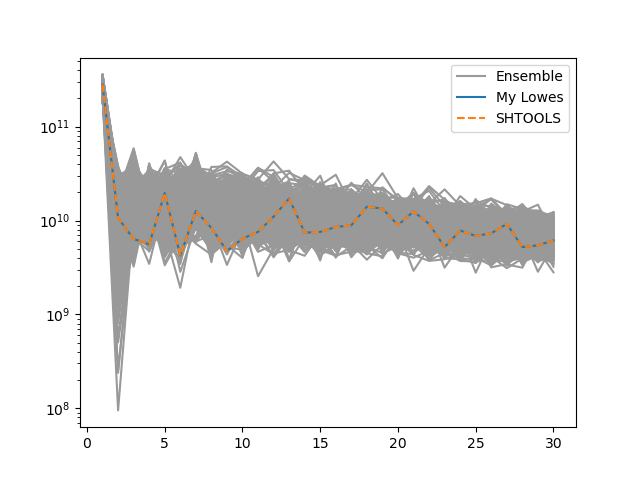

In [5]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

# g ensemble and parameters
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.legend()
plt.show()

In [6]:
#Cov based on c_angdist_range
N_range = 10000
c_angdist_range = np.linspace(-1.0,1.0,N_range)

# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_max+1)+1)/(2*np.arange(1,n_max+1)+1)

C_Br_range = []

for cmu in np.ravel(c_angdist_range):
    C_Br_range.append(np.sum(C_const.reshape(-1,1)*R*pyshtools.legendre.PlSchmidt(n_max,cmu)[1:].reshape(-1,1),axis=0))
    
C_Br_range = np.array(C_Br_range).reshape((N_range,-1))
C_Br_model = C_Br_range[:,core.ens_idx]


c_Br_range = -1*(1-2*(C_Br_range-np.min(C_Br_range,axis=0))/(np.max(C_Br_range,axis=0)-np.min(C_Br_range,axis=0)))
c_Br_model = c_Br_range[:,core.ens_idx]


<IPython.core.display.Javascript object>


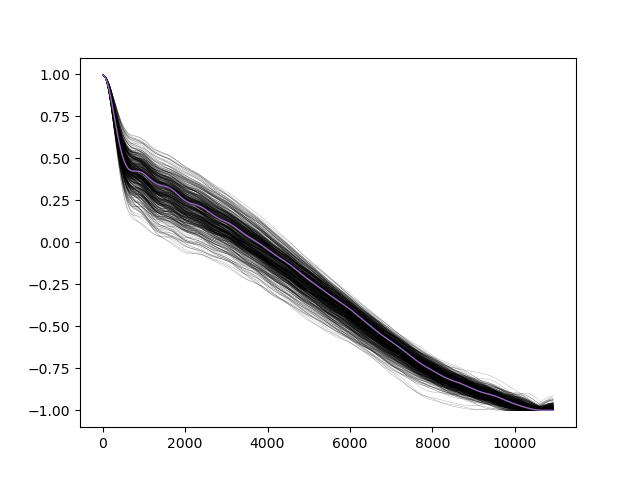

In [7]:
plt.figure()
#plt.plot(np.arccos(c_angdist_range)*180/np.pi,C_Br_range,color="k",linewidth=0.1)
plt.plot(core.r_cmb*np.arccos(c_angdist_range),c_Br_range,color="k",linewidth=0.1)
plt.plot(core.r_cmb*np.arccos(c_angdist_range),c_Br_model,color="C4",linewidth=1.0)
plt.show()

In [8]:
model_cov = c_Br_model
model_gcd = core.r_cmb*np.arccos(c_angdist_range)

In [9]:
#Spherical
#def cov_return(t, c, c0, c1):
#    return c0+c1*(1+1/2*t/c)*(1-t/c)**2
#p0 = [10**3,0.0,np.max(C_Br_model)]
#bounds = ([0,0,0],inf)
#popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
#cov_sph = cov_return(model_gcd, popt[0], popt[1], popt[2])
#print("Spherical:", popt)
#
##Power exp
#def cov_return(t, c, c0, c1,a):
#    return c0+c1*np.exp(-(t/c)**a)
#p0 = [10**1,0.0,np.max(C_Br_model),0.5]
#bounds = ([0,0,0,0.0001],[inf,inf,inf,1])
#popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
#cov_pexp = cov_return(model_gcd, popt[0], popt[1], popt[2], popt[3])
#print("Power exp:", popt)
#
##Gen Cauchy
#def cov_return(t, c, c0, c1, a, tau):
#    return c0+c1*(1+(t/c))**(-tau/a)
#p0 = [10**1,0.0,np.max(C_Br_model),0.5, 0.5]
#bounds = ([0,0,0,0.0001, 0.0001],[inf,inf,inf,1, 1])
#popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
#cov_cauchy = cov_return(model_gcd, popt[0], popt[1], popt[2], popt[3], popt[4])
#print("Gen Cauchy:", popt)
#
##Askey
#def cov_return(t, c, c0, c1, tau):
#    return c0+c1*(1-t/c)**tau
#p0 = [10**10,0.0,np.max(C_Br_model),3]
#bounds = ([0,0,0,2],[inf,inf,inf,inf])
#popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
#cov_ask = cov_return(model_gcd, popt[0], popt[1], popt[2], popt[3])
#print("Askey:", popt)

#C2-Wendland
Nfit = 9950
model_gcd_fit = model_gcd[Nfit:]
model_cov_fit = model_cov[Nfit:]
def cov_return(t, c, tau):
    return (1+tau*t/c)*(1-t/c)**tau

p0 = [10**7,4]
bounds = ([0,4],inf)
popt, _ = curve_fit(cov_return, model_gcd_fit, model_cov_fit, bounds=bounds, p0 = p0)
cov_C2 = cov_return(model_gcd, popt[0], popt[1])#, popt[2], popt[3]
print("C2-Wendland:", popt)

#cov_C2 = (np.max(C_Br_model)-np.min(C_Br_model))*cov_C2+np.min(C_Br_model)
cov_C2 = (np.max(C_Br_model)-np.min(C_Br_model))*(-cov_C2-1)/-2 + np.min(C_Br_model)

##C4-Wendland
#def cov_return(t, c, c0, c1, tau):
#    return c0+c1*(1+tau*t/c+(tau**2-1)/3*t**2/c**2)*(1-t/c)**tau
#
#p0 = [10**7,0.0,np.max(C_Br_model),8]
#bounds = ([0,0,0,6],[inf,inf,inf,inf])
#popt, _ = curve_fit(cov_return, model_gcd, model_cov, bounds=bounds, p0 = p0)
#cov_C4 = cov_return(model_gcd, popt[0], popt[1], popt[2], popt[3])
#print("C4-Wendland:", popt)

C2-Wendland: [3793065.97028335   12938.39824936]


<IPython.core.display.Javascript object>


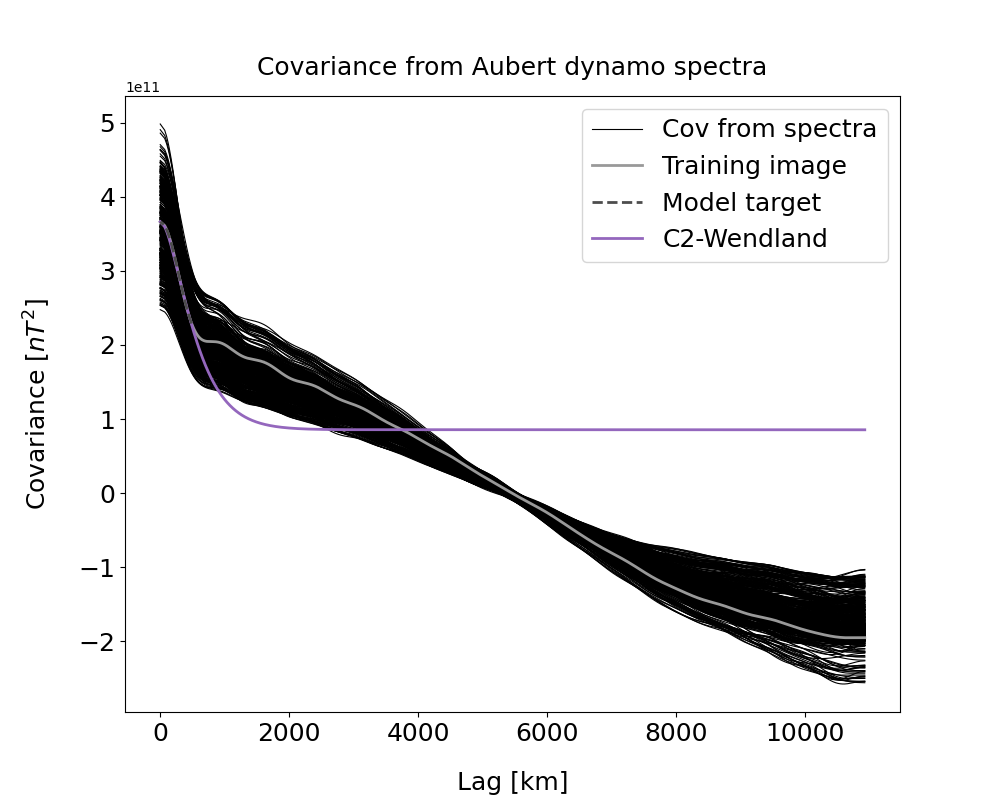

In [10]:
#%% PLOT COVARIANCE FROM RANGE
plt.figure(figsize=(10,8)) 

for i in np.arange(0,C_Br_range.shape[-1]):
    if i == 0:
        plt.plot(model_gcd,C_Br_range[:,0], 
                 linewidth = 0.8, color="k", label='Cov from spectra', zorder=0.1)
    else:
        plt.plot(model_gcd,C_Br_range[:,i], 
                 linewidth = 0.8, color="k", zorder=0.1)
        
plt.plot(model_gcd, C_Br_model, 
         linewidth = 2.0, color=(0.6,0.6,0.6), label='Training image', zorder=0.2)

plt.plot(model_gcd_fit, C_Br_model[Nfit:], 
         linewidth = 2.0, color=(0.3,0.3,0.3), label='Model target', zorder=0.3, linestyle = "dashed")

#plt.plot(core.lags, core.target_var - core.pics, 
#         linewidth = 2.0, color="C6", label='SV Training image', zorder=0.1)
#
#plt.plot(core.lags_sv_curve,core.target_var - core.sv_curve, 
#         linewidth = 2.0, color='C1', label='SV model', zorder=0.1)

#plt.plot(model_gcd, cov_sph, 
#         linewidth = 2.0, color="C0", label='Spherical', zorder=0.3)
#
#plt.plot(model_gcd, cov_pexp, 
#         linewidth = 2.0, color="C7", label='Power exp', zorder=0.3)
#
#plt.plot(model_gcd, cov_cauchy, 
#         linewidth = 2.0, color="C2", label='Gen Cauchy', zorder=0.3)
#
#plt.plot(model_gcd, cov_ask, 
#         linewidth = 2.0, color="C3", label='Askey', zorder=0.3)

plt.plot(model_gcd, cov_C2, 
         linewidth = 2.0, color="C4", label='C2-Wendland', zorder=0.25)

#plt.plot(model_gcd, cov_C4, 
#         linewidth = 2.0, color="C5", label='C4-Wendland', zorder=0.3)



plt.ylabel('Covariance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Covariance from Aubert dynamo spectra",fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [11]:
def cov_return(t, c, tau):
    return (1+tau*t/c)*(1-t/c)**tau

p0 = [10**7,4]
bounds = ([0,4],inf)
popt, _ = curve_fit(cov_return, model_gcd_fit, model_cov_fit, bounds=bounds, p0 = p0)
cov_C2 = cov_return(model_gcd, popt[0], popt[1])#, popt[2], popt[3]
print("C2-Wendland:", popt)

#cov_C2 = (np.max(C_Br_model)-np.min(C_Br_model))*cov_C2+np.min(C_Br_model)
cov_C2 = (np.max(C_Br_model)-np.min(C_Br_model))*(-cov_C2-1)/-2 + np.min(C_Br_model)

C2-Wendland: [3793065.97028335   12938.39824936]


In [12]:
# Compute cos(angdist) array for model parameter sphere
theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [core.grid_theta.reshape(1,-1), core.grid_theta.reshape(-1,1), 
                                      core.grid_phi.reshape(1,-1), core.grid_phi.reshape(-1,1)])

c_angdist = np.cos(theta_d)*np.cos(theta_s)+np.multiply(np.sin(theta_d)@np.sin(theta_s),np.cos(phi_d-phi_s))

c_angdist[c_angdist>1] = 1.0

sph_d = core.r_cmb*np.arccos(c_angdist)

In [13]:
Cm = cov_return(sph_d, popt[0], popt[1]) #, popt[2], popt[3]

#Cm = (np.max(C_Br_model)-np.min(C_Br_model))*Cm+np.min(C_Br_model)
Cm = (np.max(C_Br_model)-np.min(C_Br_model))*(-Cm-1)/-2 + np.min(C_Br_model)

In [14]:
Cm.shape

(1891, 1891)

<IPython.core.display.Javascript object>


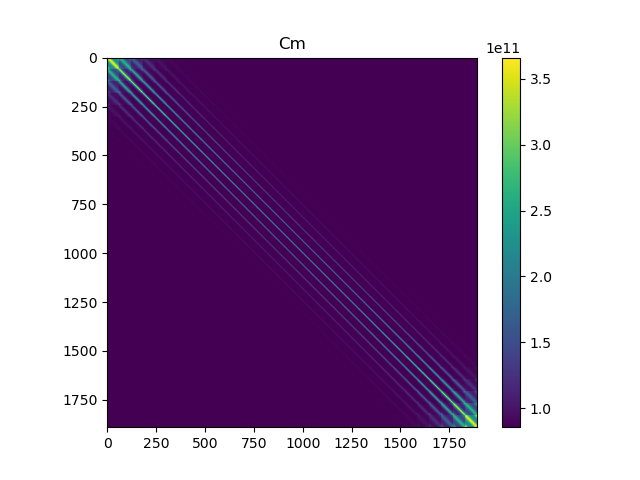

C_Br_model is pos def: True
All eigenvalues > 0: True
Number of negative eigenvalues: 0 / 1891


<IPython.core.display.Javascript object>


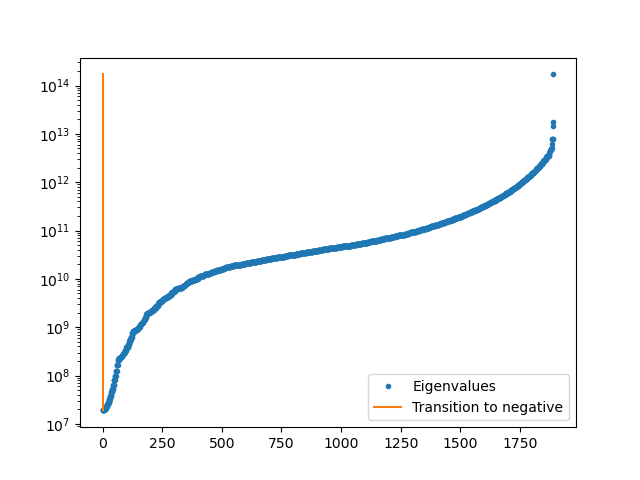

In [15]:
plt.figure()
plt.title("Cm")
plt.imshow(Cm)
plt.colorbar()
plt.show()

# Positive definite covariance?
core_eigval = spl.eigh(Cm, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(Cm))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()

# Synthetic sat

In [16]:
C_e_const = 2.0

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth

In [17]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [18]:
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = Cm)

# SDSSIM

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 16.017 minutes 
Total elapsed time: 16.017 minutes 
Variance: 283320014524.220
Mean: -11875.588
Max: 1716419.308
Min: -1368167.220
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 16.381 minutes 
Total elapsed time: 32.398 minutes 
Variance: 279502053536.323
Mean: -13044.335
Max: 1744016.994
Min: -1573997.665
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 16.262 minutes 
Total elapsed time: 48.659 minutes 
Variance: 288505520580.855
Mean: -5607.814
Max: 1808586.703
Min: -1454416.791
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 16.269 minutes 
Total elapsed time: 1.082 hours 
Variance: 286438510065.588
Mean: -8124.680
Max: 1814536.210
Min: -1484902.985
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realiz

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 10.351 minutes 
Total elapsed time: 7.119 hours 
Variance: 279780543980.610
Mean: -10942.387
Max: 1601792.086
Min: -1700921.877
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 10.862 minutes 
Total elapsed time: 7.300 hours 
Variance: 294395357520.341
Mean: -15946.972
Max: 1797213.782
Min: -1751566.127
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 12.145 minutes 
Total elapsed time: 7.502 hours 
Variance: 283764390312.453
Mean: -7132.878
Max: 1806118.035
Min: -1543704.213
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 10.495 minutes 
Total elapsed time: 7.677 hours 
Variance: 285181446275.600
Mean: -7420.288
Max: 1737793.230
Min: -1748125.171
Run nr.: 38

 |OOOOOOOOOO| 100.0%   realiza

 |OOOOOOOOOO| 100.0%   realization nr. 68. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 10.373 minutes 
Total elapsed time: 13.237 hours 
Variance: 289020184250.898
Mean: -11635.540
Max: 1803367.326
Min: -1426313.164
Run nr.: 69

 |OOOOOOOOOO| 100.0%   realization nr. 69. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 10.343 minutes 
Total elapsed time: 13.409 hours 
Variance: 285085329035.734
Mean: -10149.430
Max: 1805124.546
Min: -1784966.771
Run nr.: 70

 |OOOOOOOOOO| 100.0%   realization nr. 70. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 10.896 minutes 
Total elapsed time: 13.591 hours 
Variance: 283343449000.164
Mean: -16452.982
Max: 1902352.997
Min: -1556437.808
Run nr.: 71

 |OOOOOOOOOO| 100.0%   realization nr. 71. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 10.635 minutes 
Total elapsed time: 13.768 hours 
Variance: 292755435873.717
Mean: -12861.321
Max: 1883023.746
Min: -2245407.827
Run nr.: 72

 |OOOOOOOOOO| 100.0%   r

<IPython.core.display.Javascript object>


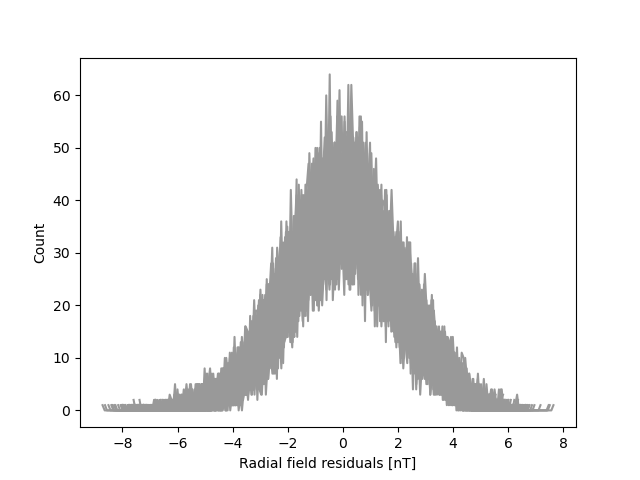

In [19]:
N_sim = 100
core.target_var = np.max(Cm)
#core.target_var = np.var(core.data)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [20]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [21]:
core.covmod_lsq_equiv(s_sat.data, Cm, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


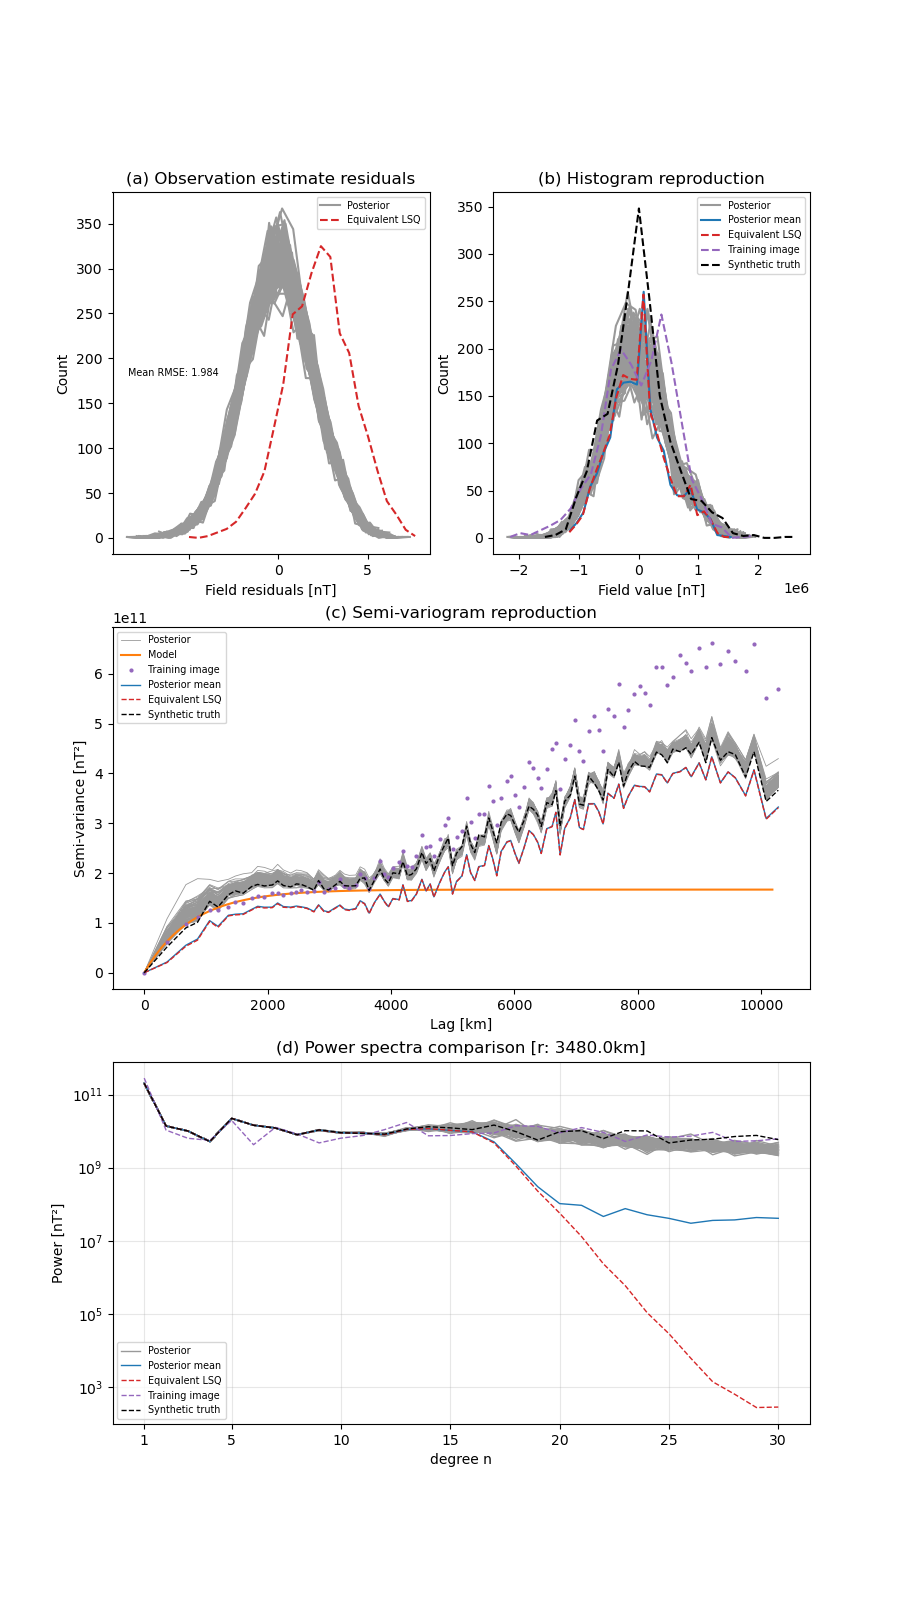

In [22]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {}, figsize=(9,16),
                              hist_bins = 25, res_bins = 25,
                              savefig = False, save_string = "core_sh30_newTI", save_dpi = 300)

In [23]:
core.grid_glq(nmax = 400, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


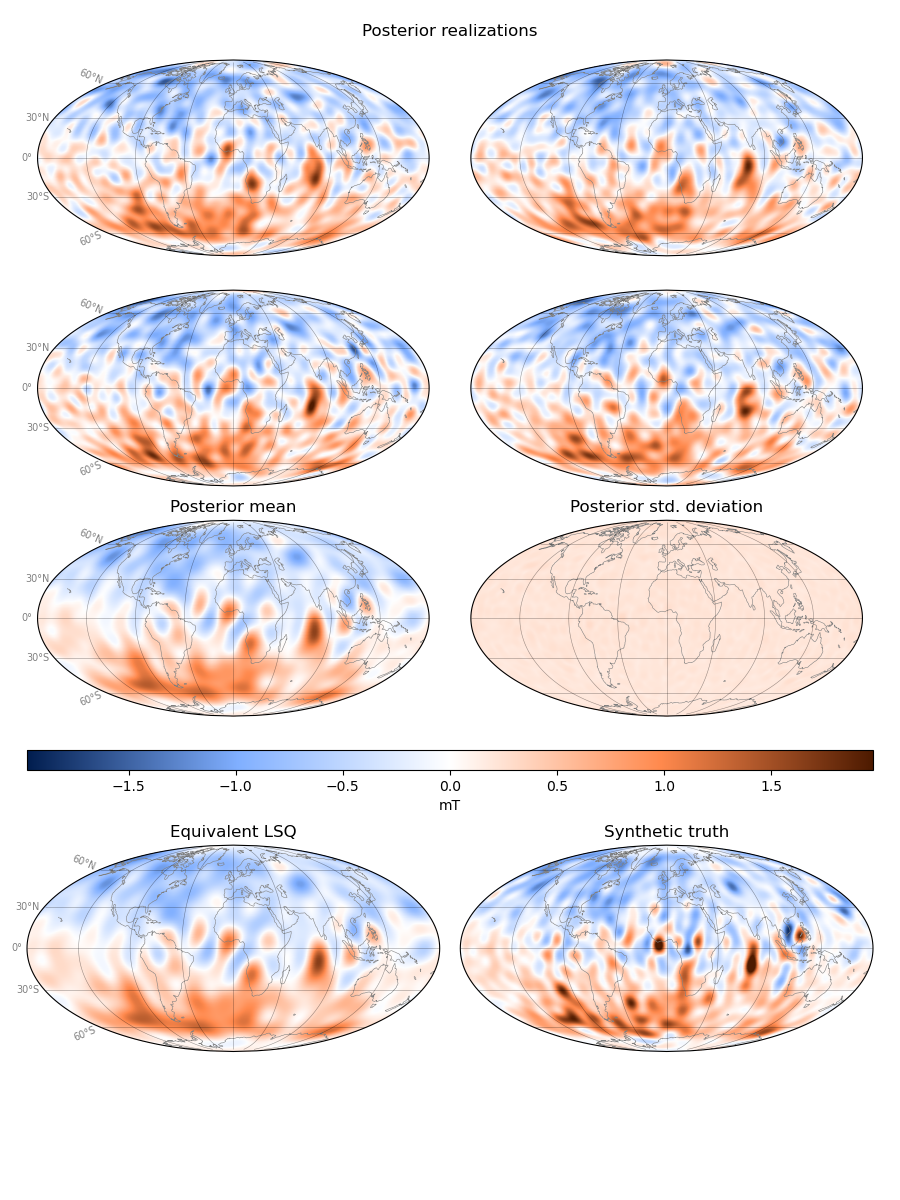

In [24]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = lsq_eqa, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


<IPython.core.display.Javascript object>


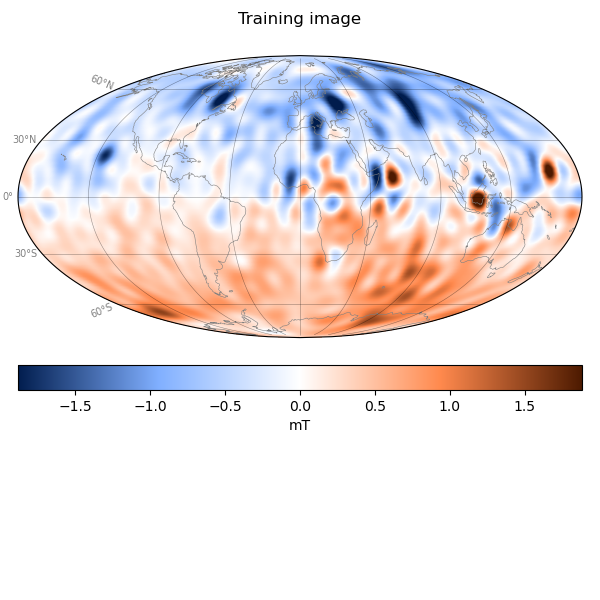

In [25]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
training_image = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=training_image, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Training image', point_size=1,
                savefig = False, save_dpi = 100, save_string ="core_sh30_synth_TI",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [27]:
np.min(core.sph_d[core.sph_d>0.0])

27.325697459670902